Notebook to explore the random Embed trained at p =0.50 (Compressed computation type) (Potentially representation with bias)

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response, plot_phase_diagram_polysem
from toy_cis.plot import plot_weight_bars, plot_phase_diagram, plot_phase_diagram_training
from toy_cis.util import threshold_matrix, in_out_response #performance_across_sparsities

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A100-SXM4-80GB'


In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response, plot_phase_diagram_polysem
from toy_cis.plot import plot_weight_bars, plot_phase_diagram, plot_phase_diagram_training
from toy_cis.util import threshold_matrix, in_out_response #performance_across_sparsities

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A100-SXM4-80GB'


In [ ]:
# Initialize models

"""ReLU + x model with Identity embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    name = "ReluPlusX_NoEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)


"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000,
)

In [ ]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.50

In [ ]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

In [ ]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

In [ ]:
"""Select represented and unrepresented features"""

idx_repr = np.where(np.diag(output-input) > 0.5)[0]
idx_unrepr = np.where(np.diag(output-input) < 0.5)[0]

print("Represented indices (diagonal):", idx_repr)
print("Unrepresented indices (diagonal):", idx_unrepr)

# --- Prepare to sample inputs and store outputs ---
num_samples = 10  # number of samples for each group
n_features = 100

outputs_repr_rep = []    # outputs when only represented features (diagonal ones) are active
outputs_repr_norm_rep = [] 
outputs_repr_unrep = [] 
outputs_repr_norm_unrep = [] 
active_counts_rep = []
active_counts_unrep = []

# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_repr) + 1, 5):
    #if k == 1: 
    #    num_samples = 100
    #else:
    #    num_samples = 10
    num_samples = int(np.ceil(100 / k))
    for _ in range(num_samples):
        # Represented features
        x_repr = t.zeros(n_features, device=device)
        chosen_repr = np.random.choice(idx_repr, size=k, replace=False)
        x_repr[t.tensor(chosen_repr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_repr = model(x_repr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_repr - x_repr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_repr_norm_rep.append(norm_y_np[idx_repr])
        outputs_repr_norm_unrep.append(norm_y_np[idx_unrepr])

# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr_norm_rep])
flat_norm_outputs_unre = np.concatenate([o.flatten() for o in outputs_repr_norm_unrep])


# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_repr, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_repr, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Represented Features")

ax2.scatter(flat_norm_outputs_unre, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_unre, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Represented Features")

#plt.title("Model Output vs. Number of Active Represented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_repr[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output (Raw)")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Represented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

active_counts_rep = []
active_counts_unrep = []
outputs_unrepr_rep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_rep = [] 
outputs_unrepr_unrep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_unrep = [] 
# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_unrepr) + 1, 5):
    #if k == 1: 
    #    num_samples = 100
    #else:
    #    num_samples = 10
    num_samples = int(np.ceil(100 / k))
    for _ in range(num_samples):
        # Represented features
        x_unrepr = t.zeros(n_features, device=device)
        chosen_unrepr = np.random.choice(idx_unrepr, size=k, replace=False)
        x_unrepr[t.tensor(chosen_unrepr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_unrepr = model(x_unrepr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_unrepr - x_unrepr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_unrepr_norm_rep.append(norm_y_np[idx_repr])
        outputs_unrepr_norm_unrep.append(norm_y_np[idx_unrepr])
        
# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_un = np.concatenate([o.flatten() for o in outputs_unrepr_norm_unrep])
flat_norm_outputs_re = np.concatenate([o.flatten() for o in outputs_unrepr_norm_rep])

# --- Plot the outputs vs. number of active features ---
# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_re, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_re, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Unrepresented Features")

ax2.scatter(flat_norm_outputs_un, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_un, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Unrepresented Features")

#plt.title("Model Output vs. Number of Active Unepresented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_re[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Unrepresented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
# IN PROGRESS: 

"""Select represented and unrepresented features"""

idx_repr = np.where(np.diag(output-input) > 0.5)[0]
idx_unrepr = np.where(np.diag(output-input) < 0.5)[0]

print("Represented indices (diagonal):", idx_repr)
print("Unrepresented indices (diagonal):", idx_unrepr)

# --- Prepare to sample inputs and store outputs ---
num_samples = 10  # number of samples for each group
n_features = 100

outputs_repr_rep = []    # outputs when only represented features (diagonal ones) are active
outputs_repr_norm_rep = [] 
outputs_repr_unrep = [] 
outputs_repr_norm_unrep = [] 
active_counts_rep = []
active_counts_unrep = []

# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_repr) + 1, 5):
    #if k == 1: 
    #    num_samples = 100
    #else:
    #    num_samples = 10
    num_samples = int(np.ceil(100 / k))
    for _ in range(num_samples):
        # Represented features
        x_repr = t.zeros(n_features, device=device)
        chosen_repr = np.random.choice(idx_repr, size=k, replace=False)
        x_repr[t.tensor(chosen_repr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_repr = model(x_repr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_repr - x_repr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_repr_norm_rep.append(norm_y_np[idx_repr])
        outputs_repr_norm_unrep.append(norm_y_np[idx_unrepr])

# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_repr = np.concatenate([o.flatten() for o in outputs_repr_norm_rep])
flat_norm_outputs_unre = np.concatenate([o.flatten() for o in outputs_repr_norm_unrep])


# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_repr, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_repr, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Represented Features")

ax2.scatter(flat_norm_outputs_unre, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_unre, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Represented Features")

#plt.title("Model Output vs. Number of Active Represented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_repr[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output (Raw)")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Represented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_RepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

active_counts_rep = []
active_counts_unrep = []
outputs_unrepr_rep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_rep = [] 
outputs_unrepr_unrep = []  # outputs when only unrepresented features (diagonal ones) are active  
outputs_unrepr_norm_unrep = [] 
# For each sample, we create an input vector of zeros,
# then randomly select a subset of either idx_repr or idx_unrepr to activate with a value (e.g., 1).
for k in range(1, len(idx_unrepr) + 1, 5):
    #if k == 1: 
    #    num_samples = 100
    #else:
    #    num_samples = 10
    num_samples = int(np.ceil(100 / k))
    for _ in range(num_samples):
        # Represented features
        x_unrepr = t.zeros(n_features, device=device)
        chosen_unrepr = np.random.choice(idx_unrepr, size=k, replace=False)
        x_unrepr[t.tensor(chosen_unrepr, device=device)] = 1.0  # active value
        with t.no_grad():
            y_unrepr = model(x_unrepr.unsqueeze(0).unsqueeze(0))  # shape (1, output_dim)
        norm_y_repr = y_unrepr - x_unrepr
        norm_y_repr = norm_y_repr.squeeze(0).squeeze(0)
        active_counts_rep.append([k] * len(idx_repr))
        active_counts_unrep.append([k] * len(idx_unrepr))
        norm_y_np = norm_y_repr.cpu().numpy()
        outputs_unrepr_norm_rep.append(norm_y_np[idx_repr])
        outputs_unrepr_norm_unrep.append(norm_y_np[idx_unrepr])
        
# --- Flatten the results for plotting ---
flat_counts_rep = np.concatenate([np.array(o).flatten() for o in active_counts_rep])
flat_counts_unrep = np.concatenate([np.array(o).flatten() for o in active_counts_unrep])
flat_norm_outputs_un = np.concatenate([o.flatten() for o in outputs_unrepr_norm_unrep])
flat_norm_outputs_re = np.concatenate([o.flatten() for o in outputs_unrepr_norm_rep])

# --- Plot the outputs vs. number of active features ---
# --- Plot the outputs vs. number of active features ---
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 10))

ax1.scatter(flat_norm_outputs_re, flat_counts_rep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_re, y=flat_counts_rep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax1) 
ax1.set_xlabel("Output for represented features")
ax1.set_ylabel("Number of Active Unrepresented Features")

ax2.scatter(flat_norm_outputs_un, flat_counts_unrep, alpha=0.7)
sns.kdeplot(x=flat_norm_outputs_un, y=flat_counts_unrep, cmap='magma', fill=False, thresh=0.05, levels=20, 
            bw_adjust=1, label='bw_adjust=0.5', ax=ax2) 
ax2.set_xlabel("Output for Unrepresented features")
ax2.set_ylabel("Number of Active Unrepresented Features")

#plt.title("Model Output vs. Number of Active Unepresented Features")
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_contour.png" 
plt.savefig(filename, dpi=300)
plt.show()

# Now group by the unique active count values.
unique_counts_rep = np.unique(flat_counts_rep)
unique_counts_unrep = np.unique(flat_counts_unrep)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 10))
for count in unique_counts_rep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_re[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax1.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax1.set_xlabel("Model Output")
ax1.set_ylabel("Frequency")
ax1.set_title("Output for represented features")

for count in unique_counts_unrep:
    # Select outputs corresponding to the current active feature count.
    group_outputs = flat_norm_outputs_unre[flat_counts_rep == count]
    # Plot a histogram (with step outline) for this group.
    ax2.hist(group_outputs, bins=20, histtype="step", linewidth=2, label=f"{int(count)} active features")

ax2.set_xlabel("Model Output")
ax2.set_ylabel("Frequency")
ax2.set_title("Output for Unrepresented features")

# Remove legends from individual axes.
ax1.legend().remove()
ax2.legend().remove()

# Create a combined legend for the entire figure.
# We can combine handles and labels from one of the axes (assuming they are consistent).
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', 
           bbox_to_anchor=(0.98, 0.5), title="Active Unrepresented Features")

# Adjust layout to account for the legend outside.
plt.tight_layout(rect=[0, 0, 0.9, 1])

filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_UnrepresentedFeaturesActive_hist.png" 
plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

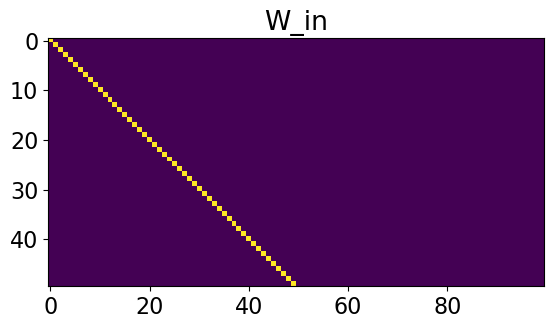

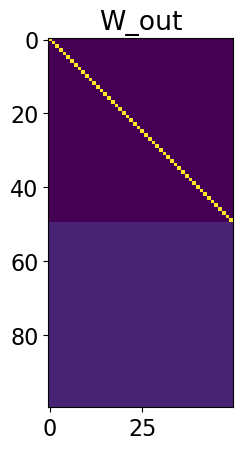

Testing over sparsities: 100%|██████████| 28/28 [00:00<00:00, 128.05it/s]


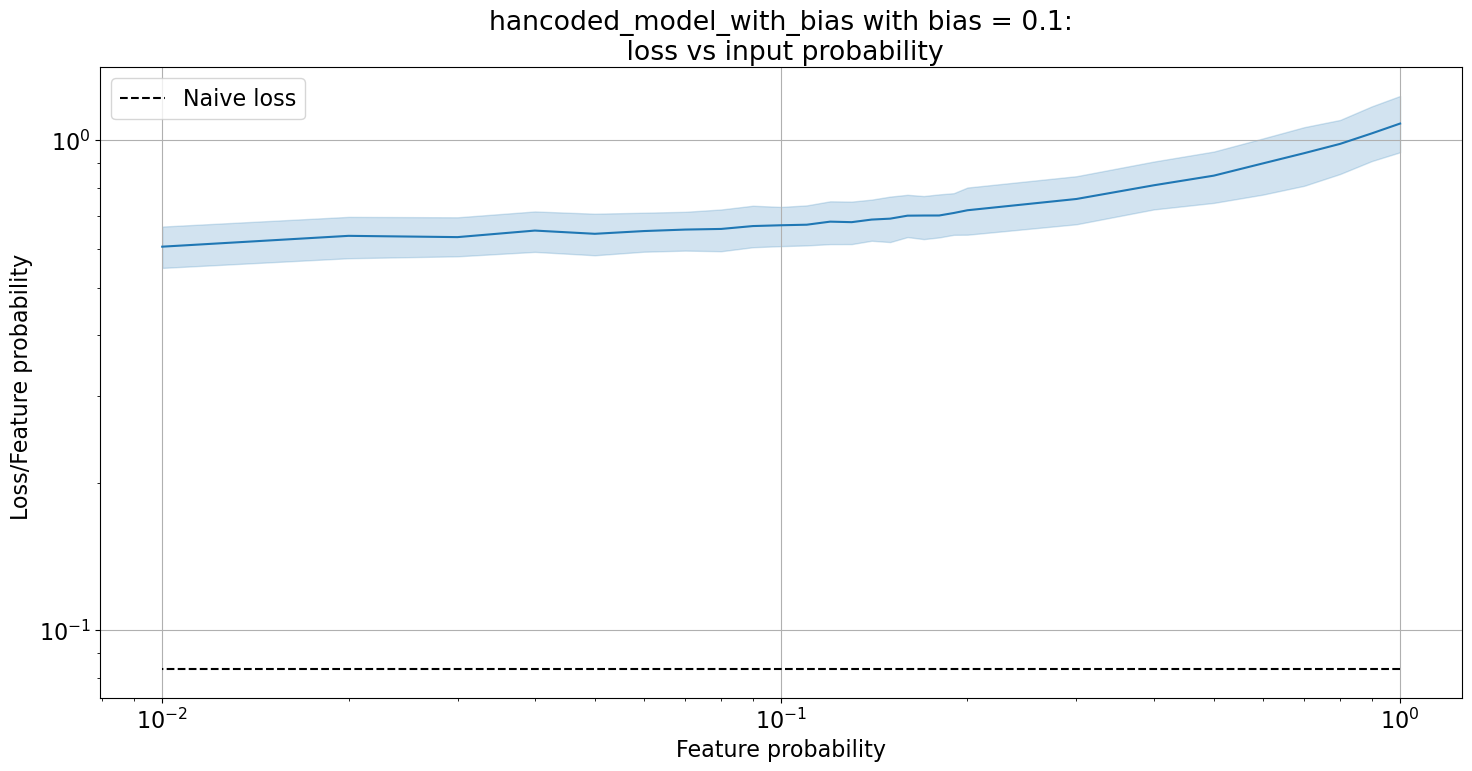

In [14]:
# Make a simple single MLP ReLU model that only contains identity matrices. Then in W_out, set the values for all unrepresented features 
# to different bias values and find the bias that causes a behaviour similar to the one seen for the random Embed ReLU + x model trained at p=0.5. 

# Build model
class TrivialMLP50(nn.Module):
    def __init__(self, bias, input_dim=100, hidden_dim=50):
        super().__init__()
        # 1) first layer: project input_dim→hidden_dim by copying the first hidden_dim features
        self.n_instances = 1
        self.n_feat = 100
        self.device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
        
        self.mlp_in = nn.Linear(input_dim, hidden_dim, bias=False)
        self.mlp_in.weight.data.zero_()
        for i in range(hidden_dim):
            self.mlp_in.weight.data[i, i] = 1.0
        #print(self.mlp_in.weight.data.shape)
        #print(self.mlp_in.weight.data)
        plt.figure()
        plt.imshow(self.mlp_in.weight.data)
        plt.title('W_in')
        plt.show()

        # 2) second layer: hidden_dim→input_dim    identity for the first hidden_dim outputs, and 0.01 bias for the rest
        self.mlp_out = nn.Linear(hidden_dim, input_dim, bias=False)
        self.mlp_out.weight.data.zero_()
        for i in range(hidden_dim):
            self.mlp_out.weight.data[i, i] = 1.0
        unrepr = list(range(hidden_dim, input_dim))
        #print(self.mlp_out.weight.data.shape)
        #for col,row in enumerate(unrepr): 
        self.mlp_out.weight.data[unrepr, :] = bias
        #print(self.mlp_out.weight.data)
        plt.figure()
        plt.imshow(self.mlp_out.weight.data)
        plt.title('W_out')
        plt.show()
        
    def forward(self, x: Float[Tensor, "batch 1 d_neurons"]) -> Float[Tensor, "batch d_neurons"]:
        # Linear in (no bias here)
        x = x.squeeze(1)
        #print('x shape = ', x.shape)
        #print('ml_in.weight shape = ', self.mlp_in.weight.shape)
        mid_pre_act: Float[Tensor, "batch d_neurons"] = einsum(x, self.mlp_in.weight,"batch d_input, d_neurons d_input -> batch d_neurons")
        # Activation
        #print('mid_pre_act shape = ', mid_pre_act.shape)
        mid: Float[Tensor, "batch d_neurons"] = F.relu(mid_pre_act)
        # Linear out
        #print('mid shape = ', mid.shape)
        #print('ml_out.weight shape = ', self.mlp_out.weight.shape)
        out: Float[Tensor, "batch d_input"] = einsum(mid, self.mlp_out.weight,"batch d_neurons, d_input d_neurons  -> batch d_input")
        return out.unsqueeze(1)

    def gen_batch_reluPlusX (self, batch_sz: int, sparsity: float | Float[t.Tensor, "inst feat"]) -> (
        tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
    ):
        """Generates a batch of x, y data."""
        # Randomly generate features vals, and for each, randomly set which samples are non-zero
        shape = (batch_sz, self.n_instances, self.n_feat)
        x = t.rand(*shape, device=self.device) * 2 - 1  # [-1, 1]
        is_active = (
            t.rand(*shape, device=self.device) < (1 - sparsity)
        )
        x *= is_active
        #print('x.shape = ', x.shape)
        return x, x + t.relu(x)

def performance_across_sparsities(sparsities, model, loss_data=None, feat_sparsity=None, n_steps=None):

    if loss_data is None:
        loss_data = []  # will store mean loss data
        
    pbar = tqdm(sparsities, desc="Testing over sparsities")
    n_examples = 10000
    for s in pbar:
    
        with t.no_grad():
            # generate examples of inputs
            x, y_true = model.gen_batch_reluPlusX (n_examples, s)
            
            # compute mean loss
            y = model.forward(x)
            loss = (y - y_true) ** 2
            #print('loss shape = ', loss.shape)
            
            # store loss at sparsity level
            loss = rearrange(loss, "examples 1 features -> examples features")
            loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
            #print('loss shape = ', loss.shape)
            for feat_idx, val in enumerate(loss):
                if feat_sparsity is None:
                    if n_steps is None:
                        loss_data.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})
                    else:
                        loss_data.append({"sparsity": s, "steps": n_steps, "feature_idx": feat_idx, "loss_per_feature": val})
                else:
                    if n_steps is None:
                        loss_data.append({"train_sparsity":feat_sparsity, "input_sparsity": s, 
                                      "feature_idx": feat_idx, "loss_per_feature": val})
                    else: 
                        loss_data.append({"train_sparsity":feat_sparsity, "n_steps":n_steps,"input_sparsity": s, 
                                      "feature_idx": feat_idx, "loss_per_feature": val})
    return loss_data

def plot_loss_sparsities(
    loss_data, sparsities, model_name, bias
)-> plt.Figure:
    """
    Plots normalized loss per feature vs. input sparsity.

    Args:
        loss_data (dict): Dictionary with keys 'sparsity' and 'loss_per_feature'.
        sparsities (np.ndarray): 1D array of sparsity values used to compute naive loss.
        model_name (str): Name of the model (for plot title and legend).
    """
    
    # convert loss data to DataFrame, convert sparsity to probability and adjust loss
    df_loss = pd.DataFrame(loss_data) 
    df_loss["FeatProb"] = 1 - df_loss["sparsity"]
    df_loss["loss/FeatProb"] = df_loss["loss_per_feature"] / df_loss["FeatProb"]
    
    naive_loss = 0.5 * (1 - sparsities) / 6 # compute naive loss (monosemantic solution)
    norm_loss = naive_loss.ravel() / (1 - sparsities)
    
    # plot performance vs input sparsity
    fig = plt.figure(figsize=(15, 8))
    sns.lineplot(data = df_loss, x = "FeatProb", y = "loss/FeatProb")
    
    # add naive loss line
    plt.plot(1- sparsities, norm_loss, linestyle="dashed", color="black", label=r"Naive loss") 
    
    # add labels and scale
    plt.xlabel('Feature probability')
    plt.xscale("log")
    plt.yscale("log")
    plt.grid()
    plt.legend(loc = "best", fontsize = 16)
    plt.ylabel('Loss/Feature probability ')
    plt.title(f"{model_name} with bias = {bias}:\n loss vs input probability")
    plt.tight_layout()
    return fig
    
#  Define model
biases = np.linspace(0.005, 0.9, 20)
bias = 0.1
device = t.device("cuda" if t.cuda.is_available() else "cpu")
model = TrivialMLP50(bias = bias).to(device)

# Test performance across sparsities
sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_sparsities(loss_data, sparsities, "hancoded_model_with_bias", bias)

# save figure and show
filename = f"/workspace/hancoded_model_with_bias_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [13]:
import time
from collections.abc import Iterable
from dataclasses import dataclass
from typing import Literal

import einops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from jaxtyping import Float
from torch import Tensor, nn
from tqdm import tqdm

# %%
resid_factor = 0.5


def naive_loss(n_features: int, d_mlp: int, p: float) -> float:
    """Naive loss from monosemantic ReLUs and orthogonal(!) embeddings."""
    return (n_features - d_mlp) / n_features * p / 6


@dataclass
class Config:
    """Configuration for the ResidualMLP model and training."""

    n_features: int = 100
    d_embed: int = 1000
    d_mlp: int = 50
    embed: Literal["random", "identity"] = "random"
    seed: int | None = None
    feature_probability: float = 0.01
    batch_size: int = 2048
    steps: int = 10_000
    lr: float = 3e-3
    print_freq: int = 500
    device: str = "cuda"


class MLP(nn.Module):
    """A simple MLP module."""

    def __init__(
        self,
        config: Config,
    ):
        d_model = config.n_features
        d_mlp = config.d_mlp
        super().__init__()
        self.d_model = d_model
        self.d_mlp = d_mlp
        device = config.device

        self.mlp_in: Float[Tensor, "d_model d_mlp"] = nn.Parameter(torch.empty(d_model, d_mlp))
        self.mlp_out: Float[Tensor, "d_mlp d_model"] = nn.Parameter(torch.empty(d_mlp, d_model))

        nn.init.kaiming_uniform_(self.mlp_in)
        nn.init.kaiming_uniform_(self.mlp_out)

    @classmethod
    def from_handcoded(cls, config: Config, bias: float = 0.01) -> "MLP":
        """Initialize a model that represents half the features perfectly, ignores the other half.

        Args:
            config: The configuration for the model.

        Returns:
            The initialized model.
        """
        instance = cls(d_model=config.n_features, d_mlp=config.d_mlp)
        instance.mlp_in.data[: config.d_mlp, :] = torch.eye(instance.d_mlp, instance.d_mlp, device=instance.mlp_in.device)
        plt.figure()
        plt.imshow(instance.mlp_in.data)
        plt.show()
        instance.mlp_out.data[:, : config.d_mlp] = torch.eye(instance.d_mlp, instance.d_mlp, device=instance.mlp_out.device)
        instance.mlp_out.data[:, config.d_mlp :] = bias
        plt.figure()
        plt.imshow(instance.mlp_out.data)
        plt.show()
        return instance

    def forward(self, x: Float[Tensor, "batch d_model"]) -> Float[Tensor, "batch d_model"]:
        mid_pre_act: Float[Tensor, "batch d_mlp"] = einops.einsum(x, self.mlp_in, "batch d_model, d_model d_mlp -> batch d_mlp")
        mid: Float[Tensor, "batch d_mlp"] = F.relu(mid_pre_act)
        out: Float[Tensor, "batch d_model"] = einops.einsum(mid, self.mlp_out, "batch d_mlp, d_mlp d_model -> batch d_model")
        return out


class EmbeddedMLPModel(nn.Module):
    """A simple MLP model with one layer, but with embeds"""

    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        if config.embed == "random":
            W_E: Float[Tensor, "n_features d_embed"] = torch.randn(config.n_features, config.d_embed, device=config.device)
        elif config.embed == "identity":
            W_E: Float[Tensor, "n_features d_embed"] = torch.eye(config.n_features, config.d_embed, device=config.device)
        else:
            raise ValueError(f"Unknown embedding type {config.embed}")
        W_E = F.normalize(W_E, dim=1)
        self.register_buffer("W_E", W_E)

        self.mlp = MLP(
            d_model=config.d_embed,
            d_mlp=config.d_mlp,
        )

    def forward(self, x: Float[Tensor, "batch n_features"]) -> Float[Tensor, "batch n_features"]:
        residual = einops.einsum(x, self.W_E, "batch n_features, n_features d_embed -> batch d_embed")
        residual = self.mlp(residual)
        out: Float[Tensor, "batch n_features"] = einops.einsum(residual, self.W_E, "batch d_embed, n_features d_embed -> batch n_features")
        return out


class ResidualMLPModel(nn.Module):
    """A simple residual MLP model with one layer."""

    def __init__(self, config: Config):
        super().__init__()
        self.config = config

        if config.embed == "random":
            W_E: Float[Tensor, "n_features d_embed"] = torch.randn(config.n_features, config.d_embed, device=config.device)
        elif config.embed == "identity":
            W_E: Float[Tensor, "n_features d_embed"] = torch.eye(config.n_features, config.d_embed, device=config.device)
        else:
            raise ValueError(f"Unknown embedding type {config.embed}")
        W_E = F.normalize(W_E, dim=1)
        self.register_buffer("W_E", W_E)

        self.mlp = MLP(
            d_model=config.d_embed,
            d_mlp=config.d_mlp,
        )

    def forward(self, x: Float[Tensor, "batch n_features"]) -> Float[Tensor, "batch n_features"]:
        residual = einops.einsum(x, self.W_E, "batch n_features, n_features d_embed -> batch d_embed")
        mlp_out: Float[Tensor, "batch d_embed"] = self.mlp(residual)
        residual = resid_factor * residual + mlp_out
        out: Float[Tensor, "batch n_features"] = einops.einsum(residual, self.W_E, "batch d_embed, n_features d_embed -> batch n_features")
        return out


def transplant_to_mlp(model: ResidualMLPModel, config: Config) -> MLP:
    """Transplant the residual MLP model into a new MLP model."""
    mlp = MLP(
        d_model=config.n_features,
        d_mlp=config.d_mlp,
    )
    W_in = einops.einsum(model.W_E, model.mlp.mlp_in, "n_features d_embed, d_embed d_mlp -> n_features d_mlp")
    W_out = einops.einsum(model.mlp.mlp_out, model.W_E, "d_mlp d_embed, n_features d_embed -> d_mlp n_features")
    mlp.mlp_in.data = W_in.to(config.device)
    mlp.mlp_out.data = W_out.to(config.device)
    return mlp


def transplant_to_embedded_mlp(model: ResidualMLPModel, config: Config) -> EmbeddedMLPModel:
    """Transplant the residual MLP model into a new EmbeddedMLPModel model."""
    embedded_mlp = EmbeddedMLPModel(config)
    embedded_mlp.mlp.mlp_in.data = model.mlp.mlp_in.data.clone()
    embedded_mlp.mlp.mlp_out.data = model.mlp.mlp_out.data.clone()
    embedded_mlp.W_E.data = model.W_E.data.clone()
    return embedded_mlp


class SparseFeatureDataset:
    """Dataset that generates sparse feature vectors."""

    def __init__(
        self,
        config: Config,
    ):
        self.n_features = config.n_features
        self.feature_probability = config.feature_probability
        self.device = config.device

    def generate_batch(self, batch_size: int, resid: bool = True) -> tuple[Float[Tensor, "batch n_features"], Float[Tensor, "batch n_features"]]:
        batch = torch.zeros((batch_size, self.n_features), device=self.device)
        mask = torch.rand_like(batch) < self.feature_probability
        values = torch.rand_like(batch) * 2 - 1
        batch = values * mask
        if resid:
            labels = F.relu(batch) + resid_factor * batch
        else:
            labels = F.relu(batch)
        return batch, labels


def train(config: Config) -> ResidualMLPModel:
    # Generate a random number
    seed = config.seed or int(time.time())
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = ResidualMLPModel(config).to(config.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)

    dataset = SparseFeatureDataset(config)

    pbar = tqdm(range(config.steps), desc="Training")
    for step in pbar:
        batch, labels = dataset.generate_batch(config.batch_size)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = ((outputs - labels) ** 2).mean(dim=(0, 1))
        loss.backward()
        optimizer.step()

        if step % config.print_freq == 0 or step == config.steps - 1:
            pbar.set_postfix({"loss": f"{loss.item():.2e}"})

    return model


def evaluate(model: ResidualMLPModel, dataset: SparseFeatureDataset, batch_size: int = 10_000, resid: bool = True) -> float:
    resid = isinstance(model, ResidualMLPModel)
    with torch.no_grad():
        batch, labels = dataset.generate_batch(batch_size, resid=resid)
        outputs = model(batch)
        loss = ((outputs - labels) ** 2).mean(dim=(0, 1)).item()
    return loss


# %%
config = Config(
    n_features=100,
    d_embed=1000,
    d_mlp=50,
    feature_probability=0.01,
    embed="random",
    steps=10_000,
    batch_size=2048,
    device="cuda" if torch.cuda.is_available() else "cpu",
)
model = train(config)


# %%


def plot_loss_of_input_sparsity(
    models: ResidualMLPModel | list[ResidualMLPModel],
    feature_probabilities: Iterable[float],
    config: Config,
    batch_size: int = 100_000,
    labels: list[str] | None = None,
    ax: plt.Axes | None = None,
) -> plt.Figure:
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    models = [models] if not isinstance(models, list) else models

    dataset = SparseFeatureDataset(config)
    feature_probabilities = np.array(feature_probabilities)
    naive_losses = naive_loss(config.n_features, config.d_mlp, feature_probabilities)

    for i, model in enumerate(models):
        with torch.no_grad():
            losses = []
            for feature_probability in feature_probabilities:
                dataset.feature_probability = feature_probability
                loss = evaluate(model, dataset, batch_size=batch_size)
                losses.append(loss)
        losses = np.array(losses)

        ax.scatter(
            feature_probabilities,
            losses / feature_probabilities,
            s=1,
            label=labels[i] if labels else None,
        )

    ax.plot(
        feature_probabilities,
        naive_losses / feature_probabilities,
        color="k",
        ls="--",
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Feature probability p = (1-S)")
    ax.set_ylabel("Adjusted loss L / (1-S)")
    ax.legend(ncols=3, loc="center left", bbox_to_anchor=(1, 0.5))
    return fig


fig = plot_loss_of_input_sparsity(models=model, feature_probabilities=np.geomspace(0.001, 1, 100), config=config, labels=["ResidualMLP"])
ax = fig.axes[0]

#model2 = transplant_to_mlp(model, config)
#plot_loss_of_input_sparsity(models=model2, feature_probabilities=np.geomspace(0.001, 1, 100), config=config, ax=ax, labels=["Transplanted to MLP without embeddings"])

#model3 = transplant_to_embedded_mlp(model, config)
#plot_loss_of_input_sparsity(models=model3, feature_probabilities=np.geomspace(0.001, 1, 100), config=config, ax=ax, labels=["Transplanted to MLP w/ embeddings"])

model4 = MLP.from_handcoded(config)
plot_loss_of_input_sparsity(models=model4, feature_probabilities=np.geomspace(0.001, 1, 100), config=config, ax=ax, labels=["HC MLP"])

plt.show()

TypeError: MLP.__init__() got an unexpected keyword argument 'd_model'